Лабораторна робота №2 

З курсу "Основи технологій машинного навчання"

Виконав: студент гр.ТІ-72, Шевченко Руслан Святославович

Навчання моделі проводилося в Google Colab


In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 8.7MB/s 
     |████████████████████████████████| 1.1MB 18.6MB/s 
     |████████████████████████████████| 51kB 8.9MB/s 
     |████████████████████████████████| 194kB 39.2MB/s 
     |████████████████████████████████| 61kB 10.6MB/s 
Mounted at /content/gdrive


In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

#### Tabular data

In [41]:
key = os.environ.get('AZURE_SEARCH_KEY', '5fe1f5513fbf40388e53390c847ec8ea')

In [39]:
search_images_bing

<function fastbook.search_images_bing>

In [42]:
results = search_images_bing(key, 'crow')
ims = results.attrgot('content_url')
len(ims)

150

In [43]:
#hide
ims = ['https://img.gazeta.ru/files3/842/10785842/shutterstock_628026569-pic905-895x505-46627.jpg']

In [22]:
dest = 'S:\images\crow.jpg'
download_url(ims[0], dest)

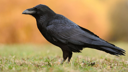

In [8]:
im = Image.open(dest)
im.to_thumb(128,128)

In [44]:
bird_types = 'crow','magpie','jackdow'
path = Path('birds')

In [10]:
if not path.exists():
    path.mkdir()
    for o in bird_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} bird')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [45]:
fns = get_image_files(path)
fns

(#412) [Path('birds/jackdow/00000054.JPG'),Path('birds/jackdow/00000062.jpg'),Path('birds/jackdow/00000049.jpg'),Path('birds/jackdow/00000086.jpg'),Path('birds/jackdow/00000021.JPG'),Path('birds/jackdow/00000063.jpg'),Path('birds/jackdow/00000115.JPG'),Path('birds/jackdow/00000140.jpg'),Path('birds/jackdow/00000111.jpg'),Path('birds/jackdow/00000006.jpg')...]

In [46]:
failed = verify_images(fns)
failed

(#9) [Path('birds/jackdow/00000110.jpg'),Path('birds/jackdow/00000050.jpg'),Path('birds/jackdow/00000105.jpg'),Path('birds/jackdow/00000074.jpg'),Path('birds/jackdow/00000017.jpg'),Path('birds/crow/00000123.jpg'),Path('birds/crow/00000097.jpg'),Path('birds/magpie/00000043.jpg'),Path('birds/magpie/00000055.jpg')]

In [47]:
failed.map(Path.unlink);

## From Data to DataLoaders

In [48]:
birds = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [49]:
dls = birds.dataloaders(path)

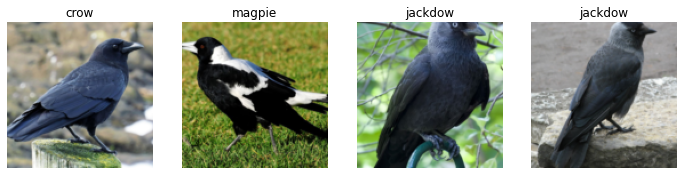

In [50]:
dls.valid.show_batch(max_n=4, nrows=1)

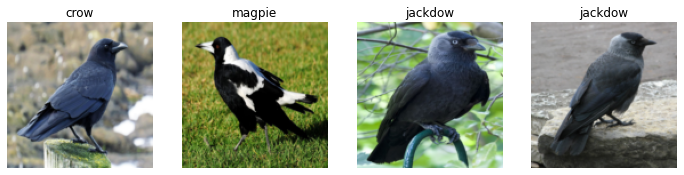

In [51]:
birds = birds.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = birds.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

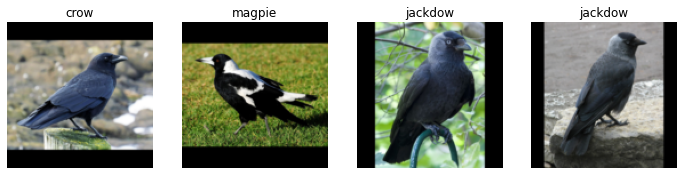

In [52]:
birds = birds.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = birds.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

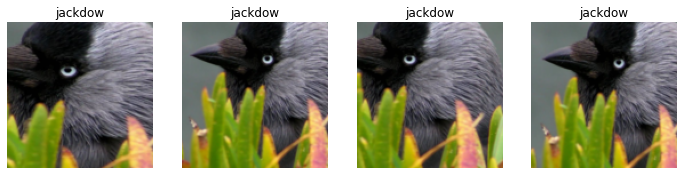

In [53]:
birds = birds.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = birds.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

### Data Augmentation

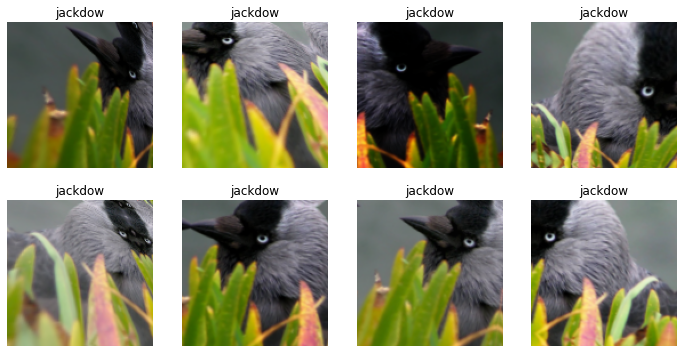

In [54]:
birds = birds.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = birds.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training Your Model, and Using It to Clean Your Data

In [56]:
birds = birds.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = birds.dataloaders(path)

In [158]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,1.795047,1.189978,0.375000,00:15


epoch,train_loss,valid_loss,error_rate,time
0,0.813901,0.728368,0.262500,00:15
1,0.695720,0.534877,0.212500,00:15
2,0.600144,0.520573,0.162500,00:14
3,0.481411,0.456125,0.137500,00:15
4,0.409454,0.437178,0.150000,00:15
5,0.348190,0.522023,0.137500,00:15
6,0.299303,0.479441,0.150000,00:15
7,0.268036,0.425404,0.150000,00:14
8,0.234054,0.388110,0.150000,00:14
9,0.208830,0.377388,0.150000,00:15


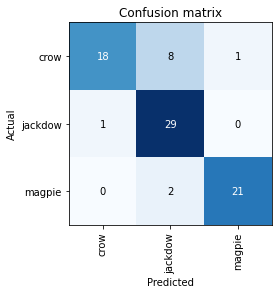

In [58]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

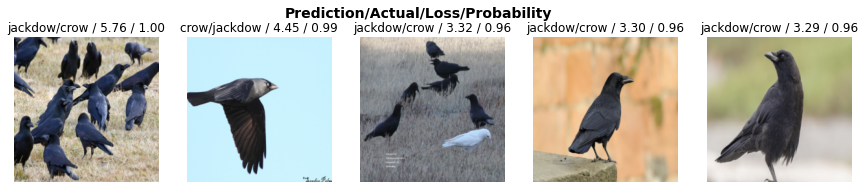

In [159]:
interp.plot_top_losses(5, nrows=1)

In [160]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [61]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

## Turning Your Model into an Online Application

### Using the Model for Inference

In [149]:
learn.export()

In [150]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [151]:
learn_inf = load_learner(path/'export.pkl')

In [152]:
learn_inf.predict('S:\images\crow.jpg')

('crow', tensor(0), tensor([9.9903e-01, 9.5922e-04, 6.0434e-06]))

In [153]:
learn_inf.dls.vocab

['crow', 'jackdow', 'magpie']

### Creating a Notebook App from the Model

In [176]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [163]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['S:\images\crow.jpg'])

In [164]:
img = PILImage.create(btn_upload.data[-1])

In [165]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [167]:
pred,pred_idx,probs = learn_inf.predict(img)

In [168]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: crow; Probability: 0.9990')

In [169]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [170]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [171]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [177]:
VBox([widgets.Label('Select your bird!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

### Turning Your Notebook into a Real App

In [80]:
#hide
#!pip install nbconvert
#!pip install voila
#!jupyter serverextension enable --sys-prefix voila 